# NSE Table for Massive Stars

This notebook uses pynucastro to generate an NSE table for use with the Castro ``massive_star`` problem.
Previously we were using a table from the [Ma et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...771...58M/abstract)
paper which used 125 nuclei binned down into the 19 nuclei used in ``aprox19``.

This table will work similarly, with the main differences:

* We are using 96 nuclei presently.  This is because (1) we don't have all the weak
  rates for the 125 nuclei used originally and (2) some ofthe nuclei in the original
  set don't have valid spins.
  
* We go only down to $Y_e = 0.43$ instead of $Y_e = 0.4$ in the original table.
  This is because of the different set of nuclei -- it is harder to achieve such
  a low $Y_e$ with our set of nuclei.

* We are using a lower temperature bound of $T = 3\times 10^9~\mathrm{K}$ instead of $10^9~\mathrm{K}$
  in the original table.  This is mainly because we don't trust NSE below this temperature.

In [1]:
import pynucastro as pyna
from pynucastro import Nucleus

## Start get getting the nuclei we care about

In [2]:
nuc_list = [Nucleus("n"), Nucleus("p"), Nucleus("d"),
            Nucleus("he3"), Nucleus("he4"), Nucleus("c12"), Nucleus("o16"),
            Nucleus("ne20"), Nucleus("ne21"), Nucleus("ne22"), Nucleus("n13"), Nucleus("n14"), Nucleus("f18"),
            Nucleus("na23"), Nucleus("mg24"), Nucleus("si28"),
            Nucleus("s32"), Nucleus("ar36"), Nucleus("ca40"), Nucleus("sc43"),
            Nucleus("al27"), Nucleus("p31"), Nucleus("cl35"), Nucleus("k39")]

We need to be careful with which nuclei we add, since some do not have spins

In [3]:
nuc_list += pyna.get_nuclei_in_range(20, 20, 45, 48)  # Ca
nuc_list += pyna.get_nuclei_in_range(21, 21, 45, 49)  # Sc
nuc_list += pyna.get_nuclei_in_range(22, 22, 44, 52)  # Ti
nuc_list += pyna.get_nuclei_in_range(23, 23, 47, 54)  # V
nuc_list += pyna.get_nuclei_in_range(24, 24, 48, 56)  # Cr
nuc_list += pyna.get_nuclei_in_range(25, 25, 51, 58)  # Mn
nuc_list += pyna.get_nuclei_in_range(26, 26, 52, 60)  # Fe
nuc_list += pyna.get_nuclei_in_range(27, 27, 54, 61)  # Co
nuc_list += pyna.get_nuclei_in_range(28, 28, 56, 65)  # Ni
nuc_list.append(Nucleus("cu59"))
nuc_list.append(Nucleus("zn60"))

In [4]:
len(nuc_list)

96

## Create our network

Find all the rates that connect these nuclei in both the ReacLib library and the tabulated rates pynucastro knows about

In [5]:
tl = pyna.TabularLibrary()
rl = pyna.ReacLibLibrary()
tlib = tl.linking_nuclei(nuc_list)
rlib = rl.linking_nuclei(nuc_list)

In [6]:
all_lib = rlib + tlib

Find any duplicates between ReacLib and the Langanke rates

In [7]:
dupes = all_lib.find_duplicate_links()

In each case, we want the `TabularRate` instead of the `ReacLibRate`

In [8]:
from pynucastro.rates import ReacLibRate
rates_to_remove = []
for d in dupes:
    rates_to_remove += [r for r in d if isinstance(r, ReacLibRate)]

for r in rates_to_remove:
    all_lib.remove_rate(r)

In [9]:
len(all_lib.get_rates())

853

## Create the RateCollection

In [12]:
rc = pyna.NSENetwork(libraries=[all_lib])

Finally let's plot the network

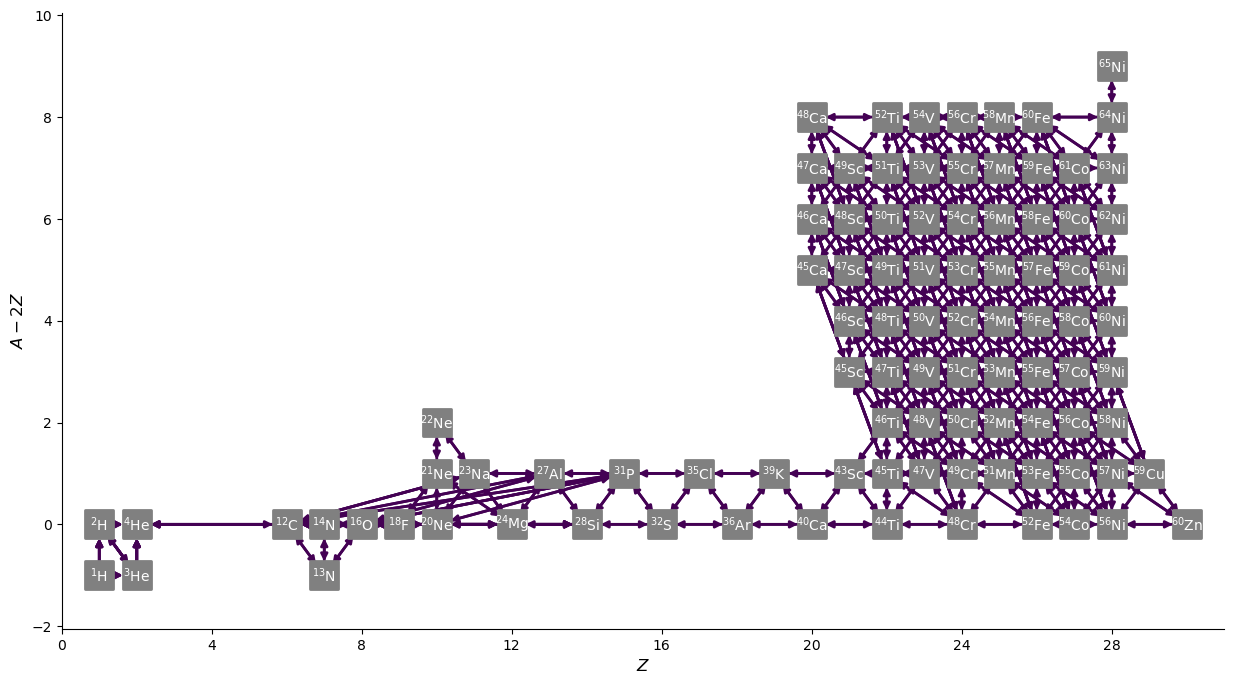

In [13]:
fig = rc.plot(hide_xalpha=True, hide_xp=True, rotated=True,
              size=(1500, 800), node_shape="s", node_size=400, node_font_size=10, node_color="0.5")

In [14]:
fig.savefig("nse_test.png")

## Test NSE solve

In [15]:
rho = 10**8.3
T = 1.e10
Ye = 0.470

In [16]:
comp, sol = rc.get_comp_nse(rho, T, Ye, use_coulomb_corr=True, return_sol=True, tol=1.e-10, init_guess=[-6.0, -11.5])

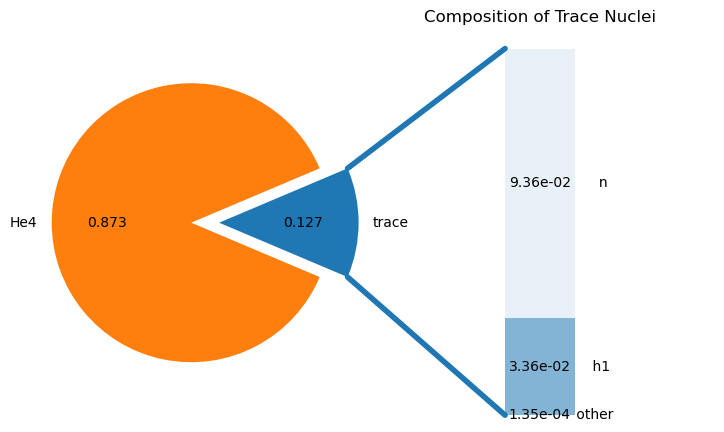

In [17]:
fig = comp.plot()

## Outputs

We want our NSE table to take the form:

$\mathrm{NSE}(\rho, T, Y_e) \rightarrow (\bar{A}, \langle B/A\rangle, dY_e/dt, d\bar{A}/dt, \tilde{X}_k, \epsilon_{\nu,\mathrm{weak}})$

where:

* $\bar{A}$ is the mean molecular weight of the full set of nuclei
  
* $\langle B/A\rangle$ is the averaging binding energy per nucleon of the full set of nuclei.  This is constructed
  as
  
  $$\left \langle \frac{B}{A} \right \rangle = \sum_k Y_k B_k$$
  
  where $B_k$ is the binding energy of nucleus $k$
  

* $dY_e/dt$ is the time-derivative of the electron fraction *due to only electron-captures and beta-decays*

  This can be constructed as:
  
  $$\frac{dY_e}{dt} = \sum_k Z_k \frac{dY_k}{dt}$$
  
  where $dY/dt$ is what is returned from the reaction network -- the change in molar abundances with time.
  
* $d\bar{A}/dt$ is the time-derivative of the mean molecular weight *due to only electron-captures and beta-decays*

  This can be constructed from the definition of $\bar{A}$
  
  $$\bar{A} = \left ( \sum_k Y_k \right )^{-1}$$
  
  by taking the time-derivative:
  
  $$\frac{d\bar{A}}{dt} = -\bar{A}^2 \sum_k \frac{dY_k}{dt}$$

* $\tilde{X}_k$ is are the reduced set of nuclei mass fractions, obtained by binning the full set of mass fractions
  obtained via NSE down to the collection we will carry on the grid.

* $\epsilon_{\nu,\mathrm{weak}}$ are the neutrino losses from the weak reactions

### mean molecular weight

We can get this directly from the `Composition` object:

In [18]:
abar = comp.eval_abar()
abar

2.8946616915459082

### average binding energy per nucleon

This can also be found via the composition object.  Note that the `Nucleus.nucbind` is already *per nucleon*

In [19]:
bea = sum(q.nucbind * comp.X[q] for q in rc.unique_nuclei)
bea

6.173089438070676

### time-derivatives

For $dY_e/dt$ and $d\bar{A}/dt$, we need the ydots for just the tabular rates

In [20]:
from pynucastro.screening import potekhin_1998
ydots = rc.evaluate_ydots(rho, T, comp, screen_func=potekhin_1998,
                          rate_filter=lambda r: isinstance(r, pyna.rates.TabularRate))

In [21]:
dYedt = sum(q.Z * ydots[q] for q in rc.unique_nuclei)
dYedt

-0.009247714569293687

In [22]:
dAbardt =- -abar**2 * sum(ydots[q] for q in rc.unique_nuclei)
dAbardt

4.506146234724346e-26

### Neutrino losses

In [23]:
    _, enu = rc.evaluate_energy_generation(rho, T, comp, screen_func=potekhin_1998, return_enu=True)
f"{enu:20.10g}"

'     9.538460879e+16'

### reduced composition

In [24]:
aprox19_comp = [Nucleus("he3"), Nucleus("he4"), Nucleus("c12"), Nucleus("n14"),
                Nucleus("o16"), Nucleus("ne20"), Nucleus("mg24"), Nucleus("si28"),
                Nucleus("s32"), Nucleus("ar36"), Nucleus("ca40"), Nucleus("ti44"),
                Nucleus("cr48"), Nucleus("fe52"), Nucleus("fe54"), Nucleus("ni56"),
                Nucleus("n"), Nucleus("p")]
reduced_comp = comp.bin_as(aprox19_comp, exclude=[Nucleus("ni56")])
reduced_comp.X

{n: 0.09362682196926209,
 p: 0.033736714508529636,
 He3: 1.250736066407676e-06,
 He4: 0.8726112354379081,
 C12: 1.9853339543427318e-05,
 N14: 5.4891094800402925e-08,
 O16: 3.015925895413388e-06,
 Ne20: 1.250962843327417e-07,
 Mg24: 1.9874473141438265e-07,
 Si28: 2.9178338749765556e-07,
 S32: 3.213285937350188e-08,
 Ar36: 2.6384020212145797e-09,
 Ca40: 1.470644003055607e-10,
 Ti44: 4.650233083418434e-08,
 Cr48: 1.8672161905730352e-07,
 Fe52: 8.073995496924405e-08,
 Fe54: 8.868505559288851e-08,
 Ni56: 1.173861663455769e-14}

## Create the table

In [ ]:
import numpy as np

$Y_e \sim 0.43$ is basically how low `aprox21` goes

In [ ]:
#Ts = np.logspace(9, 10.4, 71)
#Ts = np.logspace(np.log10(3.e9), np.log10(2.5e10), 21)
Ts = np.logspace(np.log10(3.e9), np.log10(2.e10), 51)
rhos = np.logspace(7, 10, 31)
yes = np.linspace(0.43, 0.5, 15)

we will try to cache the initial guess of $\mu_p, \mu_n$ as a function of $\rho, Y_e$

In [ ]:
mu_p0 = -3.5
mu_n0 = -15.0

In [ ]:
mu_p = np.ones((len(rhos), len(yes)), dtype=np.float64) * mu_p0
mu_n = np.ones((len(rhos), len(yes)), dtype=np.float64) * mu_n0

The first time through we will be very slow, since we are using the same initial guess for
the chemical potentials everywhere.  But after that, we will use the $(\mu_p, \mu_n)$
from the old temperature at the same $(\rho, Y_e)$ as the initial guess for the new temperature.
This should hopefully have it converge faster.

In [ ]:
for T in reversed(Ts):
    print(f"working on {T=}")
    for irho, rho in enumerate(reversed(rhos)):
        for iye, ye in enumerate(reversed(yes)):
            initial_guess = (mu_p[irho, iye], mu_n[irho, iye])
            try:
                comp, sol = rc.get_comp_nse(rho, T, ye, use_coulomb_corr=True,
                                            init_guess=initial_guess, return_sol=True)
            except ValueError:
                initial_guess = (-3.5, -15)
                comp, sol = rc.get_comp_nse(rho, T, ye, use_coulomb_corr=True,
                                            init_guess=initial_guess, return_sol=True)
                
            mu_p[irho, iye] = sol[0]
            mu_n[irho, iye] = sol[1]

In [ ]:
print(T, rho, ye)

In [ ]:
print(sol)

In [ ]:
initial_guess